**reference**: https://deap.readthedocs.io/en/master/examples/ga_onemax.html

# Setting hyperparameters

In [1]:
no_of_generations = 1000 # decide, iterations

# decide, population size or no of individuals or solutions being considered in each generation
population_size = 300 

# chromosome (also called individual) in DEAP
# length of the individual or chrosome should be divisible by no. of variables 
# is a series of 0s and 1s in Genetic Algorithm

# here, one individual may be 
# [1,0,1,1,1,0,......,0,1,1,0,0,0,0] of length 100
# each element is called a gene or allele or simply a bit
# Individual in bit form is called a Genotype and is decoded to attain the Phenotype i.e. the 
size_of_individual = 100 

# above, higher the better but uses higher resources

# we are using bit flip as mutation,
# probability that a gene or allele will mutate or flip, 
# generally kept low, high means more random jumps or deviation from parents, which is generally not desired
probability_of_mutation = 0.05 

# no. of participants in Tournament selection
# to implement strategy to select parents which will mate to produce offspring
tournSel_k = 10 

# no, of variables which will vary,here we have x and y
# this is so because both variables are of same length and are represented by one individual
# here first 50 bits/genes represent x and the rest 50 represnt y.
no_of_variables = 2

bounds = [(-6,6),(-6,6)] # one tuple or pair of lower bound and upper bound for each variable
# same for both variables in our problem 



# CXPB  is the probability with which two individuals
#       are crossed or mated
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

In [2]:
import random, numpy as np
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools

# deap.creator
convenient way of creating individuals  
arguments: 
first the desired name of the new class  
second the base class it will inherit,  
in addition any subsequent arguments you want to become attributes of your class.

First we will define the class FitnessMin. It will inherit the Fitness class of the deap.base module and contain an additional attribute called weights.  

Please mind the value of weights to be the tuple  
(1.0,) (+ve weight for maximization) or (-1.0,) (-ve weight for minmization).  
This way we will be a single objective fitness. We can’t repeat it enough, in DEAP single objectives is a special case of multi objectives.  


Next we will create the class Individual, which will inherit the class list and contain our previously defined FitnessMin class in its fitness attribute. Note that upon creation all our defined classes will be part of the creator container and can be called directly.

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


# an Individual is a list with one more attribute called fitness
creator.create("Individual", list, fitness=creator.FitnessMin)

# base.Toolbox  
Now we will use our custom classes to create types representing our individuals as well as our whole population.

All the objects we will use on our way, an individual, the population, as well as all functions, operators, and arguments will be stored in a DEAP container called Toolbox. It contains two methods for adding and removing content, register() and unregister().  

The registration of the tools to the toolbox only associates aliases to the already existing functions and freezes part of their arguments.  
This allows us to fix an arbitrary amount of argument at certain values so we only have to specify the remaining ones when calling the method.

In [4]:
# instance of Toolbox class
toolbox = base.Toolbox()

# Attribute generator, generation function 
# toolbox.attr_bool(), when called, will draw a random integer between 0 and 1
# it is equivalent to random.randint(0,1)
toolbox.register("attr_bool", random.randint, 0, 1)

## Structure initializers, initialization functions, will instantiate an individual or population.

when toolbox.individual will be called, tools.initRepeat(creator.Individual, toolbox.attr_bool, 100) will be called

When called, the individual() method will thus return an individual initialized with what would be returned by calling the attr_bool() method 100 times.
and instance of creator.Individual container will be filled using the method attr_bool(), provided as second argument, 
and will contain 100 integers, as specified using the third argument. 

population() method uses the same paradigm i.e. it will return a 'list' filled with toolbox.individual, but we don’t fix the number of individuals that it should contain.

In [5]:
# here give the no. of bits in an individual i.e. size_of_individual, here 100
# depends upon decoding strategy, which uses precision
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, size_of_individual) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Objective/Evalutaion Function
The returned value must be an iterable of a length equal to the number of objectives (no of elements in weights).

In [6]:
def decode_all_x(individual,no_of_variables,bounds):
    '''
    returns list of decoded x in same order as we have in binary format in chromosome
    bounds should have upper and lower limit for each variable in same order as we have in binary format in chromosome 
    '''
    
    len_chromosome = len(individual)
    len_chromosome_one_var = int(len_chromosome/no_of_variables)
    bound_index = 0
    x = []
    
    # one loop each for x(first 50 bits of individual) and y(next 50 of individual)
    for i in range(0,len_chromosome,len_chromosome_one_var):
        # converts binary to decimial using 2**place_value
        chromosome_string = ''.join((str(xi) for xi in  individual[i:i+len_chromosome_one_var]))
        binary_to_decimal = int(chromosome_string,2)
        
        # this formula for decoding gives us two benefits
        # we are able to implement lower and upper bounds for each variable
        # gives us flexibility to choose chromosome of any length, 
        #      more the no. of bits for a variable, more precise the decoded value can be
        lb = bounds[bound_index][0]
        ub = bounds[bound_index][1]
        precision = (ub-lb)/((2**len_chromosome_one_var)-1)
        decoded = (binary_to_decimal*precision)+lb
        x.append(decoded)
        bound_index +=1
    
    # returns a list of solutions in phenotype o, here [x,y]
    return x

def objective_fxn(individual):     
    
    # decoding chromosome to get decoded x in a list
    x = decode_all_x(individual,no_of_variables,bounds)
    
    # the formulas to decode the chromosome of 0s and 1s to an actual number, the value of x or y
    decoded_x = x[0]
    decoded_y = x[1]

    # the himmelblau function
    # min ((x**2)+y-11)**2+(x+(y**2)-7)**2
    # objective function value for the decoded x and decoded y
    obj_function_value = ((decoded_x**2)+decoded_y-11)**2+(decoded_x+(decoded_y**2)-7)**2
    
    # the evaluation function needs to return an iterable with each element corresponding to 
    #     each element in weights provided while inheriting from base.fitness
    return [obj_function_value] 

# Constraint  
Himmelblau Function has four solutions for finding global minima.  
f(3.0 2.0)              = 0.0     
f(-2.805118, 3.131312)  = 0.0  
f(-3.779310, -3.283186) = 0.0  
f(3.584428, -1.848126)  = 0.0  

The constraint implemented here is that sum of both variables should be less than 0  
x + y < 0  

This leaves us with only one feasible soulution, 
f(-3.779310, -3.283186) = 0.0  

In [7]:
def check_feasiblity(individual):
    '''
    Feasibility function for the individual. 
    Returns True if individual is feasible (or constraint not violated),
    False otherwise
    '''
    var_list = decode_all_x(individual,no_of_variables,bounds)
    if sum(var_list) < 0:
        return True
    else:
        return False


def penalty_fxn(individual):
    '''
    Penalty function to be implemented if individual is not feasible or violates constraint
    It is assumed that if the output of this function is added to the objective function fitness values,
    the individual has violated the constraint.
    '''
    var_list = decode_all_x(individual,no_of_variables,bounds)
    return sum(var_list)**2

# The Genetic Operators   
Within DEAP there are two ways of using operators. We can either simply call a function from the tools module or register it with its arguments in a toolbox, as we have already seen for our initialization methods. The most convenient way, however, is to register them in the toolbox, because this allows us to easily switch between the operators if desired.

Registering the genetic operators required for the evolution in our problem and their default arguments in the toolbox is done as follows.

The evaluation will be performed by calling the alias evaluate. It is important to not fix its argument in here. We will need it later on to apply the function to each separate individual in our population. The mutation, on the other hand, needs an argument to be fixed (the independent probability of each attribute to be mutated indpb).

### Constraint function
The penalty decorator takes 2 mandatory arguments and an optional one.  
The first argument is a function returning the validity of an individual according to user defined constraints.  
The second argument is a constant value delta(Δ) returned when an individual is not valid. The third optional argument is a penalty function which returns penalty value added to delta, the sum of both is then returned as fitness value. This last argument takes on the default value of 0.

In [8]:
# registering objetive function with constraint
toolbox.register("evaluate", objective_fxn) # privide the objective function here
toolbox.decorate("evaluate", tools.DeltaPenalty(check_feasiblity, 1000, penalty_fxn)) # constraint on our objective function

# registering basic processes using bulit in functions in DEAP
toolbox.register("mate", tools.cxTwoPoint) # strategy for crossover, this classic two point crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=probability_of_mutation) # mutation strategy with probability of mutation
toolbox.register("select", tools.selTournament, tournsize=tournSel_k) # selection startegy

# Statistics and Logbook  
creating a logbook to track statistics in each generation

creating statistics for each generation

In [9]:
stats = tools.Statistics()

# registering the functions to which we will pass the list of fitness's of a gneration's offspring
# to ge the results
stats.register('Min', np.min)
stats.register('Max', np.max)
stats.register('Avg', np.mean)
stats.register('Std', np.std)

logbook = tools.Logbook()

# Tracking best individual of each generation using HallOfFame

In [10]:
# first argument is for 'maxsize' which signifies maximum number of best individuals to select from the population
# here we are selecting just one i.e. the one best individual out of population
# if we use update method of HallOfFame object, 
# then it will select and store best individual from it, here 1
# if we put one more population in Update method, it will again choose the best individual and
# compare it with earlier stored individual and keep the best out of it.
# in the end we will get the best individual which will go into 'Hall Of Fame'
hall_of_fame = tools.HallOfFame(1)

# Evolving the Population/Implementation of Algorithm

Once the representation and the genetic operators are chosen, we will define an algorithm combining all the individual parts and performing the evolution of our population until the optimization problem is solved. It is good style in programming to do so within a function, generally named main().

## Creating the Population

First of all, we need to actually instantiate our population. But this step is effortlessly done using the population() method we registered in our toolbox earlier on.  

pop will be a list composed of 300 individuals. Since we left the parameter n open during the registration of the population() method in our toolbox, we are free to create populations of arbitrary size.

In [11]:
# create poppulation as coded in population class
# no. of individuals can be given as input
pop = toolbox.population(n=population_size)

# The next thing to do is to evaluate our brand new population.

# use map() from python to give each individual to evaluate and create a list of the result
fitnesses = list(map(toolbox.evaluate, pop)) 


# zip takes two iterables of same size and iterates over them together
# ind has individual and fit has fitness score
# individual class in deap has fitness.values attribute which is used to store fitness value
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# evolve our population until we reach the number of generations

# Variable keeping track of the number of generations
g = 0
# clearing hall_of_fame object as precaution before every run
hall_of_fame.clear()

# Begin the evolution
while g < no_of_generations:
    # A new generation
    g = g + 1
    #print("-- Generation %i --" % g)
    
    
    #The evolution itself will be performed by selecting, mating, and mutating the individuals in our population.
    
    # the first step is to select the next generation.
    # Select the next generation individuals using select defined in toolbox here tournament selection
    # the fitness of populations is decided from the individual.fitness.values[0] attribute
    #      which we assigned earlier to each individual
    # these are best individuals selected from population after selection strategy
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals, this needs to be done to create copy and avoid problem of inplace operations
    # This is of utter importance since the genetic operators in toolbox will modify the provided objects in-place.
    offspring = list(map(toolbox.clone, offspring))
    
    # Next, we will perform both the crossover (mating) and the mutation of the produced children with 
    #        a certain probability of CXPB and MUTPB. 
    # The del statement will invalidate the fitness of the modified offspring as they are no more valid 
    #       as after crossover and mutation, the individual changes
    
    # Apply crossover and mutation on the offspring
    # note, that since we are not cloning, the changes in child1, child2 and mutant are happening inplace in offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values 
                
                
    # Evaluate the individuals with an invalid fitness (after we use del to make them invalid)
    # again note, that since we did not use clone, each change happening is happening inplace in offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    
    # To check the performance of the evolution, we will calculate and print the 
    # minimal, maximal, and mean values of the fitnesses of all individuals in our population 
    # as well as their standard deviations.
    # Gather all the fitnesses in one list and print the stats
    #this_gen_fitness = [ind.fitness.values[0] for ind in offspring]
    this_gen_fitness = [] # this list will have fitness value of all the offspring
    for ind in offspring:
        this_gen_fitness.append(ind.fitness.values[0])            
    
    
    #### SHORT METHOD
    
    # will update the HallOfFame object with the best individual 
    #   according to fitness value and weight (while creating base.Fitness class)
    hall_of_fame.update(offspring)
    
    # pass a list of fitnesses 
    # (basically an object on which we want to perform registered functions)
    # will return a dictionary with key = name of registered function and value is return of the registered function
    stats_of_this_gen = stats.compile(this_gen_fitness)
    
    # creating a key with generation number
    stats_of_this_gen['Generation'] = g
    
    # printing for each generation
    print(stats_of_this_gen)
    
    # recording everything in a logbook object
    # logbook is essentially a list of dictionaries
    logbook.append(stats_of_this_gen)
    
    
    # now one generation is over and we have offspring from that generation
    # these offspring wills serve as population for the next generation
    # this is not happening inplace because this is simple python list and not a deap framework syntax
    pop[:] = offspring

{'Min': 10.025587063268894, 'Max': 1127.8505254373483, 'Avg': 666.7555825695912, 'Std': 397.8956516198327, 'Generation': 1}
{'Min': 1.8579720574199667, 'Max': 1292.4584681526492, 'Avg': 664.4920749007263, 'Std': 419.4448930211802, 'Generation': 2}
{'Min': 5.030019621524256, 'Max': 1124.559206671666, 'Avg': 660.813790132448, 'Std': 412.17046797224356, 'Generation': 3}
{'Min': 1.5213866619995995, 'Max': 1175.7744929351975, 'Avg': 577.5357905172364, 'Std': 415.29531483705085, 'Generation': 4}
{'Min': 5.682222986454252, 'Max': 1125.3426758802352, 'Avg': 635.7431212315319, 'Std': 419.36669947494727, 'Generation': 5}
{'Min': 7.713388487809738, 'Max': 1137.6303446196896, 'Avg': 591.672376291553, 'Std': 415.2715907806115, 'Generation': 6}
{'Min': 6.951657469862232, 'Max': 1215.7059047524967, 'Avg': 694.133395557854, 'Std': 396.5769327834104, 'Generation': 7}
{'Min': 1.353912076671333, 'Max': 1353.9945788270202, 'Avg': 626.0260436070164, 'Std': 409.1445630241901, 'Generation': 8}
{'Min': 6.4134

{'Min': 2.611859051942911, 'Max': 1159.0450740098363, 'Avg': 655.5699516346164, 'Std': 401.2032478949746, 'Generation': 67}
{'Min': 4.59676972598838, 'Max': 1140.512362242885, 'Avg': 669.0385713538275, 'Std': 393.01732349889943, 'Generation': 68}
{'Min': 12.409134868978674, 'Max': 1397.3631992677203, 'Avg': 632.8979060581779, 'Std': 414.6078985143661, 'Generation': 69}
{'Min': 5.31454588937081, 'Max': 1115.6154456980776, 'Avg': 607.9901237581133, 'Std': 412.58105347542585, 'Generation': 70}
{'Min': 3.5351499633012122, 'Max': 1287.6916200300802, 'Avg': 596.8553903306369, 'Std': 424.0437883772292, 'Generation': 71}
{'Min': 18.684660308668885, 'Max': 1130.2358327031368, 'Avg': 649.8762045552743, 'Std': 405.8558755173497, 'Generation': 72}
{'Min': 6.255739100866222, 'Max': 1138.5045716520801, 'Avg': 639.6567345333876, 'Std': 413.1305810999081, 'Generation': 73}
{'Min': 1.648498955503225, 'Max': 1134.8725644320662, 'Avg': 598.891010069894, 'Std': 411.8728926565841, 'Generation': 74}
{'Min':

{'Min': 4.404955866130868, 'Max': 1174.9145304963936, 'Avg': 666.9492329929277, 'Std': 408.0535691565239, 'Generation': 133}
{'Min': 5.207867423403538, 'Max': 1128.7796875238998, 'Avg': 611.8829722538982, 'Std': 420.90760063801446, 'Generation': 134}
{'Min': 2.6948775182433566, 'Max': 1203.0991765934177, 'Avg': 644.3525366950827, 'Std': 409.18038910842165, 'Generation': 135}
{'Min': 5.106508539064664, 'Max': 1321.9200475423054, 'Avg': 643.025164079612, 'Std': 412.5235620216644, 'Generation': 136}
{'Min': 3.8944707891495653, 'Max': 1233.4652751729325, 'Avg': 689.2116490181528, 'Std': 398.92268544897337, 'Generation': 137}
{'Min': 4.987290913552206, 'Max': 1536.1014781885017, 'Avg': 649.6347455599766, 'Std': 401.8512046547819, 'Generation': 138}
{'Min': 7.125751363211599, 'Max': 1125.0485990130564, 'Avg': 624.6554511864329, 'Std': 416.1572529613374, 'Generation': 139}
{'Min': 1.7276416585508332, 'Max': 1286.0681469659594, 'Avg': 627.8648029218488, 'Std': 414.83361979212856, 'Generation':

{'Min': 7.183027709240027, 'Max': 1126.0560042020263, 'Avg': 641.517776379063, 'Std': 401.4212971129372, 'Generation': 199}
{'Min': 3.0161886441931305, 'Max': 1263.4911256857877, 'Avg': 583.1659009573351, 'Std': 430.36517465068147, 'Generation': 200}
{'Min': 7.410394108328288, 'Max': 1166.4969809512727, 'Avg': 654.2412047708232, 'Std': 414.88377315972645, 'Generation': 201}
{'Min': 12.908858516204834, 'Max': 1127.7380004190022, 'Avg': 706.5548318943847, 'Std': 389.89194543925834, 'Generation': 202}
{'Min': 2.3335359193185514, 'Max': 1241.6344460019388, 'Avg': 663.4754363553747, 'Std': 406.10429598723323, 'Generation': 203}
{'Min': 12.172841396119766, 'Max': 1117.456904564912, 'Avg': 673.451472742841, 'Std': 398.5081855179742, 'Generation': 204}
{'Min': 21.58023771302217, 'Max': 1136.0159398215944, 'Avg': 662.5907047762396, 'Std': 408.53000945816825, 'Generation': 205}
{'Min': 1.879347056380672, 'Max': 1130.573918618186, 'Avg': 643.5433599708177, 'Std': 406.3949832776715, 'Generation': 

{'Min': 2.540862532484573, 'Max': 1142.4164901326667, 'Avg': 639.9024739991936, 'Std': 413.2948880197897, 'Generation': 265}
{'Min': 8.879408837162345, 'Max': 1426.3238977494382, 'Avg': 660.9301357704132, 'Std': 411.9011723608481, 'Generation': 266}
{'Min': 1.066051340113035, 'Max': 1118.5657113738882, 'Avg': 614.7450352696488, 'Std': 419.62901829995394, 'Generation': 267}
{'Min': 6.956090585393115, 'Max': 1128.3560643377946, 'Avg': 622.8575234243783, 'Std': 414.31249679601007, 'Generation': 268}
{'Min': 0.6695127895859616, 'Max': 1140.6530491030994, 'Avg': 632.6876683293442, 'Std': 412.7032281572064, 'Generation': 269}
{'Min': 9.65029675477224, 'Max': 1182.6986149857112, 'Avg': 648.3226608720224, 'Std': 408.02990018034205, 'Generation': 270}
{'Min': 3.155098324496615, 'Max': 1124.85827128715, 'Avg': 601.681346172801, 'Std': 408.5659068803042, 'Generation': 271}
{'Min': 2.425764495439529, 'Max': 1385.5210983470486, 'Avg': 673.7735001638553, 'Std': 394.34330537570224, 'Generation': 272}

{'Min': 3.5548775104469312, 'Max': 1186.8853509910662, 'Avg': 670.9112797474064, 'Std': 400.9768098717766, 'Generation': 331}
{'Min': 18.29179445568253, 'Max': 1125.98850489628, 'Avg': 639.4922982088448, 'Std': 419.16059951279016, 'Generation': 332}
{'Min': 3.4102532532748704, 'Max': 1233.2363983891232, 'Avg': 623.3197569890328, 'Std': 419.23368799748704, 'Generation': 333}
{'Min': 1.7569245976123224, 'Max': 1133.5450505355057, 'Avg': 620.984938740468, 'Std': 399.66582586907936, 'Generation': 334}
{'Min': 0.3507796458118237, 'Max': 1120.6404977946113, 'Avg': 704.6705917232002, 'Std': 395.2701526725256, 'Generation': 335}
{'Min': 9.24223316237978, 'Max': 1122.5022885040203, 'Avg': 631.256152485055, 'Std': 406.7691383386897, 'Generation': 336}
{'Min': 2.502974127499473, 'Max': 1133.7306337834584, 'Avg': 639.8771637569262, 'Std': 413.57935023653, 'Generation': 337}
{'Min': 1.7658038654127222, 'Max': 1202.5545954764727, 'Avg': 627.5030470317025, 'Std': 410.19459403722755, 'Generation': 338

{'Min': 8.099708404708549, 'Max': 1130.7762747550714, 'Avg': 667.2193804476611, 'Std': 406.1304353197352, 'Generation': 397}
{'Min': 7.3322595844504015, 'Max': 1203.8552374119217, 'Avg': 603.043872966706, 'Std': 416.7642998641101, 'Generation': 398}
{'Min': 3.3512504939845247, 'Max': 1233.1233284791483, 'Avg': 635.2071529225163, 'Std': 409.1745742655639, 'Generation': 399}
{'Min': 6.552013307634082, 'Max': 1117.4593518685808, 'Avg': 689.5414893008412, 'Std': 402.14134833374845, 'Generation': 400}
{'Min': 9.88243799735148, 'Max': 1186.3162168520084, 'Avg': 685.0913605259583, 'Std': 402.5857939612986, 'Generation': 401}
{'Min': 5.146217210109309, 'Max': 1212.4947148704628, 'Avg': 638.3387915754549, 'Std': 418.3616331413383, 'Generation': 402}
{'Min': 11.341222392358748, 'Max': 1180.3715440840642, 'Avg': 643.5888354239977, 'Std': 400.7511170869754, 'Generation': 403}
{'Min': 6.052819243789461, 'Max': 1106.142900320773, 'Avg': 641.1175586711225, 'Std': 412.4090648240564, 'Generation': 404}

{'Min': 6.045728073962307, 'Max': 1243.497752863762, 'Avg': 680.1170226345176, 'Std': 403.78831055437007, 'Generation': 463}
{'Min': 0.30407136464191764, 'Max': 1116.4907476663723, 'Avg': 651.1417673274618, 'Std': 399.81752885196863, 'Generation': 464}
{'Min': 7.316289982281891, 'Max': 1154.0064643706382, 'Avg': 638.0716581795612, 'Std': 402.59779273757005, 'Generation': 465}
{'Min': 5.245541404789227, 'Max': 1104.6800081945648, 'Avg': 661.4289426084941, 'Std': 398.54064717355277, 'Generation': 466}
{'Min': 4.750682456160799, 'Max': 1185.818500638444, 'Avg': 651.6271679530855, 'Std': 412.5710541610336, 'Generation': 467}
{'Min': 1.4058110080846686, 'Max': 1109.8980678701391, 'Avg': 661.5602287101001, 'Std': 409.6193239400529, 'Generation': 468}
{'Min': 0.5858529883333174, 'Max': 1195.1012257244493, 'Avg': 672.0594353079999, 'Std': 413.0030735922259, 'Generation': 469}
{'Min': 2.559953851383299, 'Max': 1206.2181962043624, 'Avg': 686.6339399832146, 'Std': 409.42459183889486, 'Generation'

{'Min': 2.257525791592527, 'Max': 1118.0051137784876, 'Avg': 666.9731280488318, 'Std': 414.3024803301488, 'Generation': 529}
{'Min': 3.160785735837266, 'Max': 1225.4874297257516, 'Avg': 682.7562047851891, 'Std': 401.7041497430229, 'Generation': 530}
{'Min': 0.477447551223955, 'Max': 1347.5051389878618, 'Avg': 665.3453993871467, 'Std': 408.8414517586867, 'Generation': 531}
{'Min': 2.1804470060943695, 'Max': 1238.166805460292, 'Avg': 682.4023325625614, 'Std': 404.3734164750686, 'Generation': 532}
{'Min': 13.881155506075398, 'Max': 1133.2768682631574, 'Avg': 657.4318433698254, 'Std': 417.3851530357202, 'Generation': 533}
{'Min': 9.932521811343253, 'Max': 1275.016844860433, 'Avg': 602.0149020907566, 'Std': 410.5222654592947, 'Generation': 534}
{'Min': 7.844270298646146, 'Max': 1284.2450254989305, 'Avg': 647.7776536117067, 'Std': 410.02135523276576, 'Generation': 535}
{'Min': 6.343394235912669, 'Max': 1138.892533637544, 'Avg': 653.2899379380121, 'Std': 407.00173020573385, 'Generation': 536}

{'Min': 15.90296123406424, 'Max': 1126.4871127749723, 'Avg': 670.4956829763435, 'Std': 397.0349469671728, 'Generation': 595}
{'Min': 4.120887533772999, 'Max': 1463.319777976466, 'Avg': 663.816884804428, 'Std': 409.55455869107266, 'Generation': 596}
{'Min': 4.0040221468854815, 'Max': 1140.591764766618, 'Avg': 713.9057525035247, 'Std': 392.51757159771665, 'Generation': 597}
{'Min': 4.9308640323924156, 'Max': 1228.2968302257427, 'Avg': 599.3244878808919, 'Std': 408.27377332684716, 'Generation': 598}
{'Min': 1.4700075616094368, 'Max': 1355.133809671285, 'Avg': 634.025466830368, 'Std': 411.03657073772706, 'Generation': 599}
{'Min': 9.73223605415124, 'Max': 1272.5891796378726, 'Avg': 653.2065504294261, 'Std': 405.17576182043337, 'Generation': 600}
{'Min': 6.356483165591854, 'Max': 1138.161419277393, 'Avg': 614.6983223617914, 'Std': 412.1697135640126, 'Generation': 601}
{'Min': 7.337583214144843, 'Max': 1144.2872776757508, 'Avg': 644.8415858064053, 'Std': 418.47598927302926, 'Generation': 602

{'Min': 4.432026549647524, 'Max': 1359.07666809523, 'Avg': 627.3233201062756, 'Std': 426.0392901837267, 'Generation': 661}
{'Min': 14.139921595116828, 'Max': 1116.513175962206, 'Avg': 642.8605684933715, 'Std': 407.45692498033566, 'Generation': 662}
{'Min': 4.194226251066579, 'Max': 1236.3584540336958, 'Avg': 655.3895099912364, 'Std': 416.92445975046843, 'Generation': 663}
{'Min': 6.057942326923093, 'Max': 1265.2971251813256, 'Avg': 645.1122436538553, 'Std': 409.3998463581259, 'Generation': 664}
{'Min': 2.857536973188525, 'Max': 1160.4752079586547, 'Avg': 633.9980158474799, 'Std': 412.9598704559167, 'Generation': 665}
{'Min': 2.4222652116848704, 'Max': 1127.41940324615, 'Avg': 644.8760573552523, 'Std': 405.4051557387024, 'Generation': 666}
{'Min': 10.358638174252361, 'Max': 1119.3655409251555, 'Avg': 645.543628580475, 'Std': 406.38024274680856, 'Generation': 667}
{'Min': 3.14138394489906, 'Max': 1132.4824523079483, 'Avg': 641.5277229249277, 'Std': 394.9045606420082, 'Generation': 668}
{

{'Min': 9.209081092793625, 'Max': 1131.5320059410483, 'Avg': 624.1486100060683, 'Std': 411.41171934971675, 'Generation': 727}
{'Min': 0.6013321865665844, 'Max': 1309.9826089978149, 'Avg': 642.3673883231843, 'Std': 409.2189464408463, 'Generation': 728}
{'Min': 14.105156072161664, 'Max': 1450.2942888561056, 'Avg': 691.2176761446055, 'Std': 402.62214239026116, 'Generation': 729}
{'Min': 1.8800314693398983, 'Max': 1138.7321367534976, 'Avg': 608.309319095402, 'Std': 401.9820829295293, 'Generation': 730}
{'Min': 2.5606277199937737, 'Max': 1113.0987076249353, 'Avg': 612.6020079556603, 'Std': 414.3241361301086, 'Generation': 731}
{'Min': 1.2336317028313386, 'Max': 1128.59966753582, 'Avg': 641.6186483065204, 'Std': 412.47899525919024, 'Generation': 732}
{'Min': 6.658439450067421, 'Max': 1360.8779003666498, 'Avg': 610.4163872350905, 'Std': 414.0569304834821, 'Generation': 733}
{'Min': 14.091848274734705, 'Max': 1455.1680016599987, 'Avg': 655.1675240850276, 'Std': 406.09917725873265, 'Generation'

{'Min': 6.63346407183184, 'Max': 1130.7162974296352, 'Avg': 637.6047044109341, 'Std': 410.55730362098785, 'Generation': 793}
{'Min': 8.197639919539945, 'Max': 1371.3210605420436, 'Avg': 625.9931596782538, 'Std': 410.4247134754688, 'Generation': 794}
{'Min': 3.1888008728111994, 'Max': 1253.0321327436934, 'Avg': 663.0312587519184, 'Std': 408.26114611115867, 'Generation': 795}
{'Min': 1.3956033441719433, 'Max': 1259.6213894902496, 'Avg': 639.3634667660752, 'Std': 406.3220490627176, 'Generation': 796}
{'Min': 6.619192320541949, 'Max': 1131.6153806614088, 'Avg': 657.3974811463443, 'Std': 406.35308493208476, 'Generation': 797}
{'Min': 0.8067455842766437, 'Max': 1150.994375692769, 'Avg': 641.6180071456478, 'Std': 410.5814479948892, 'Generation': 798}
{'Min': 1.3421175106424452, 'Max': 1200.1529451628207, 'Avg': 607.9255562490207, 'Std': 422.71238457730084, 'Generation': 799}
{'Min': 2.065642097741572, 'Max': 1105.2932962869515, 'Avg': 664.5791063644505, 'Std': 405.4608968158019, 'Generation':

{'Min': 11.7065033119172, 'Max': 1140.1100867938285, 'Avg': 649.5825263189789, 'Std': 418.66380126698374, 'Generation': 859}
{'Min': 0.653642285654908, 'Max': 1133.616395823167, 'Avg': 631.5246245988039, 'Std': 411.53332474768916, 'Generation': 860}
{'Min': 0.8640198182158181, 'Max': 1225.3222111637338, 'Avg': 673.8402436430306, 'Std': 409.99677895986963, 'Generation': 861}
{'Min': 14.42530504979371, 'Max': 1126.0986493741375, 'Avg': 656.2011014641965, 'Std': 405.75956652735704, 'Generation': 862}
{'Min': 1.8560625579526697, 'Max': 1136.2053197937194, 'Avg': 651.9120244631565, 'Std': 425.97254665198716, 'Generation': 863}
{'Min': 5.407638755509881, 'Max': 1120.5257955981997, 'Avg': 626.0541201050818, 'Std': 422.7390653460601, 'Generation': 864}
{'Min': 3.7860572348450976, 'Max': 1114.215793751617, 'Avg': 607.4666441742113, 'Std': 410.3518099645017, 'Generation': 865}
{'Min': 6.194198930561803, 'Max': 1152.2819501749984, 'Avg': 633.2354297509767, 'Std': 408.362495363981, 'Generation': 8

{'Min': 0.8320156399120597, 'Max': 1128.1686076975075, 'Avg': 658.21884644804, 'Std': 408.7129342108901, 'Generation': 925}
{'Min': 0.26829933865456024, 'Max': 1116.1514447207499, 'Avg': 658.0356015853241, 'Std': 412.8162257440403, 'Generation': 926}
{'Min': 1.981519495420216, 'Max': 1127.9994178243016, 'Avg': 673.2627535979678, 'Std': 403.80036449246154, 'Generation': 927}
{'Min': 5.514450329445244, 'Max': 1117.6845230552779, 'Avg': 676.2622564130935, 'Std': 395.1880813193683, 'Generation': 928}
{'Min': 1.6606769079870396, 'Max': 1108.066588813209, 'Avg': 644.5835571437648, 'Std': 408.85927484616144, 'Generation': 929}
{'Min': 2.200841485167226, 'Max': 1259.758938727899, 'Avg': 645.0348195048251, 'Std': 416.572218168741, 'Generation': 930}
{'Min': 2.9251590198401622, 'Max': 1298.8888916071014, 'Avg': 691.8853473638227, 'Std': 404.8228368545915, 'Generation': 931}
{'Min': 2.8983017654991214, 'Max': 1121.1852475331937, 'Avg': 654.9477184678773, 'Std': 401.57506062270437, 'Generation': 9

{'Min': 5.680501678865554, 'Max': 1476.6247757260091, 'Avg': 630.5173778714197, 'Std': 411.59838452111035, 'Generation': 991}
{'Min': 0.8871937788442829, 'Max': 1144.1863313283493, 'Avg': 635.6928931528003, 'Std': 414.19492276744216, 'Generation': 992}
{'Min': 6.992197269556617, 'Max': 1118.406900026784, 'Avg': 686.4059775086544, 'Std': 403.2458455623882, 'Generation': 993}
{'Min': 10.559271832841837, 'Max': 1149.0405852806446, 'Avg': 657.9342994296807, 'Std': 407.4573803080019, 'Generation': 994}
{'Min': 6.853402024435978, 'Max': 1125.5777083982375, 'Avg': 691.3901061700291, 'Std': 406.5964446797538, 'Generation': 995}
{'Min': 6.778569574987967, 'Max': 1147.1093081538017, 'Avg': 645.3873119432295, 'Std': 411.0197213187327, 'Generation': 996}
{'Min': 0.16189641913488684, 'Max': 1120.7893375161095, 'Avg': 616.8114803747427, 'Std': 412.12194331963855, 'Generation': 997}
{'Min': 6.288402755926142, 'Max': 1122.7666655206367, 'Avg': 669.1361726067861, 'Std': 400.7901632702183, 'Generation':

# Results and Plotting

Minimum value for function:  0.01101131654241808
Optimum Solution:  [-3.7879641021042314, -3.298504163793028]


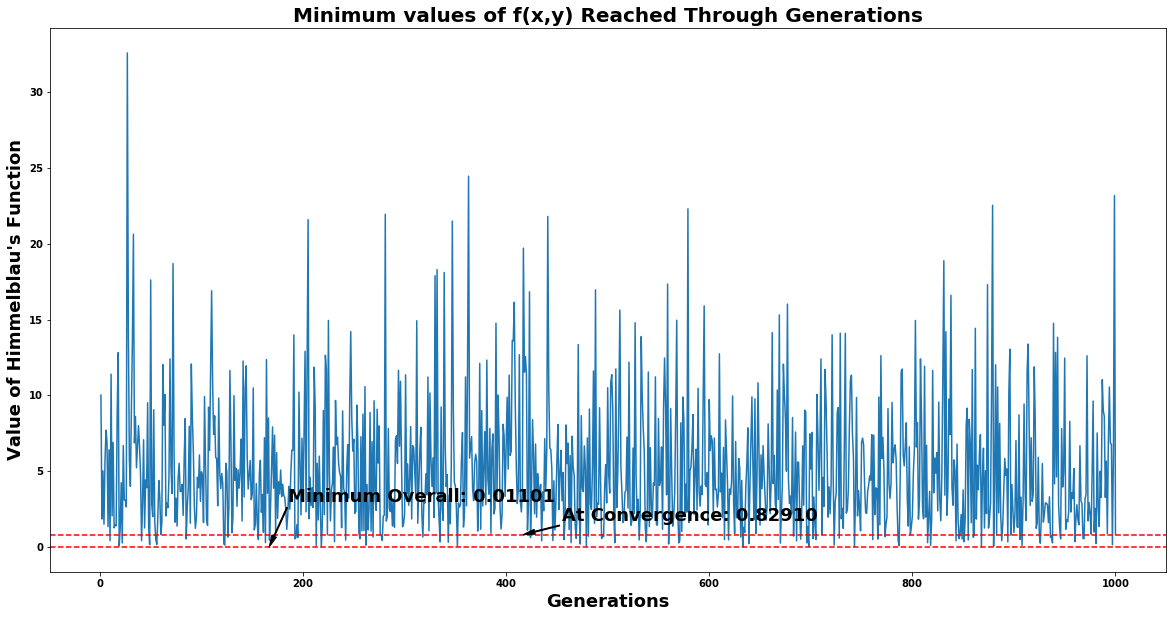

In [27]:
# print the best solution using HallOfFame object
for best_indi in hall_of_fame:
    # using values to return the value and
    # not a deap.creator.FitnessMin object
    best_obj_val_overall = best_indi.fitness.values[0]
    print('Minimum value for function: ',best_obj_val_overall)
    print('Optimum Solution: ',decode_all_x(best_indi,no_of_variables,bounds))

    
# finding the fitness value of the fittest individual of the last generation or 
# the solution at which the algorithm finally converges
# we find this from logbook

# select method will return value of all 'Min' keys in the order they were logged,
# the last element will be the required fitness value since the last generation was logged last
best_obj_val_convergence = logbook.select('Min')[-1]

# plotting Generations vs Min to see convergence for each generation

plt.figure(figsize=(20, 10))

# using select method in logbook object to extract the argument/key as list
plt.plot(logbook.select('Generation'), logbook.select('Min'))

plt.title("Minimum values of f(x,y) Reached Through Generations",fontsize=20,fontweight='bold')
plt.xlabel("Generations",fontsize=18,fontweight='bold')
plt.ylabel("Value of Himmelblau's Function",fontsize=18,fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')


# the red line at lowest value of f(x,y) in the last generation or the solution at which algorithm converged
plt.axhline(y=best_obj_val_convergence,color='r',linestyle='--')

# the red line at lowest value of f(x,y)
plt.axhline(y=best_obj_val_overall,color='r',linestyle='--')


#
if best_obj_val_convergence > 2:
    k = 0.8
elif best_obj_val_convergence > 1:
    k = 0.5
elif best_obj_val_convergence > 0.5:
    k = 0.3
elif best_obj_val_convergence > 0.3:
    k = 0.2
else:
    k = 0.1

# location of both text in terms of x and y coordinate
# k is used to create height distance on y axis between the two texts for better readability


# for best_obj_val_convergence
xyz1 = (no_of_generations/2.4,best_obj_val_convergence) 
xyzz1 = (no_of_generations/2.2,best_obj_val_convergence+(k*3)) 

plt.annotate("At Convergence: %0.5f" % best_obj_val_convergence,xy=xyz1,xytext=xyzz1,
             arrowprops=dict(facecolor='black',shrink=1,width=1,headwidth=5),
             fontsize=18,fontweight='bold')

# for best_obj_val_overall
xyz2 = (no_of_generations/6,best_obj_val_overall)
xyzz2 = (no_of_generations/5.4,best_obj_val_overall+(k/0.1))

plt.annotate("Minimum Overall: %0.5f" % best_obj_val_overall,xy=xyz2,xytext=xyzz2,
             arrowprops=dict(facecolor='black',shrink=1,width=1,headwidth=5),
             fontsize=18,fontweight='bold')

plt.show()